In [1]:
from prepare_data import preprocess_data_czech
from field_info import FieldInfo
from tensor_encoder import TensorEncoder
import pandas as pd
import tensorflow as tf
import numpy as np

2023-12-05 09:46:37.424198: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
raw_data = pd.read_csv('../DATA/tr_by_acct_w_age.csv')
data, LOG_AMOUNT_SCALE, TD_SCALE, START_DATE, TCODE_TO_NUM, NUM_TO_TCODE = preprocess_data_czech(raw_data)
data2 = data[['account_id','age','tcode', 'tcode_num', 'datetime', 'month', 'dow', 'day', 'dtme' ,'log_amount_sc','td_sc']]
df= data2.copy()

n_tcodes = len(TCODE_TO_NUM)

info = FieldInfo(n_tcodes)

max_seq_len = 80
min_seq_len = 20
df_test = df[:10]
encoder = TensorEncoder(df, info, max_seq_len, min_seq_len)


In [3]:
encoder.encode()

2023-12-05 09:47:48.676683: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-05 09:47:48.685428: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-12-05 09:47:48.714559: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2023-12-05 09:47:48.714823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2023-12-05 09:47:48.714850: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-12-05 09:4

Finished encoding 2000 of 14354 seqs
Finished encoding 4000 of 14354 seqs
Finished encoding 6000 of 14354 seqs
Finished encoding 8000 of 14354 seqs
Finished encoding 10000 of 14354 seqs
Finished encoding 12000 of 14354 seqs
Finished encoding 14000 of 14354 seqs
Took 35.26 secs


In [5]:
def make_batches(ds, buffer_size, batch_size):
    return ds.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

BUFFER_SIZE = ds_all.cardinality().numpy()
bs = 64  # batch size



In [6]:
from sklearn.model_selection import train_test_split
n_seqs, n_steps, n_feat_inp = encoder.inp_tensor.shape
x_tr, x_cv, inds_tr, inds_cv, targ_tr, targ_cv = train_test_split(encoder.inp_tensor, np.arange(n_seqs), encoder.tar_tensor, test_size=0.2)

# Create TensorFlow dataset
ds_all = tf.data.Dataset.from_tensor_slices((encoder.inp_tensor.astype(np.float32), encoder.tar_tensor.astype(np.float32)))
ds_tr = tf.data.Dataset.from_tensor_slices((x_tr.astype(np.float32), targ_tr.astype(np.float32)))
ds_cv = tf.data.Dataset.from_tensor_slices((x_cv.astype(np.float32), targ_cv.astype(np.float32)))

train_batches = make_batches(ds_tr, BUFFER_SIZE, bs)

In [13]:
from field_info import FieldInfo
fieldInfo = FieldInfo(n_tcodes)


loss_scce_logit = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

LOSS_WEIGHTS = {
 'td_sc':1.,
 'month': 0.015,
 'day': 0.025,
 'dtme': 0.025,
 'dow': 0.01,
 'tcode_num': 1.,
 'log_amount_sc': 2.}

FIELD_STARTS_TAR = fieldInfo.FIELD_STARTS_TAR
FIELD_DIMS_TAR = fieldInfo.FIELD_DIMS_TAR
LOSS_TYPES = fieldInfo.LOSS_TYPES

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return  -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)


def loss_function(real, preds):
    loss_parts = []
    loss_parts_weighted = []
    mask = tf.math.logical_not(tf.math.equal(tf.reduce_sum(real, axis=2), 0))
    for k, k_pred in preds.items():
        st = FIELD_STARTS_TAR[k]
        end = st + FIELD_DIMS_TAR[k]
        loss_type = LOSS_TYPES[k]
        if loss_type == "scce":
           loss_ = loss_scce_logit(real[:, :, st:end], k_pred)
        elif loss_type == "pdf":
           temp = -log_normal_pdf(real[:, :, st:end], k_pred[:,:,0:1], k_pred[:,:,1:2])
           loss_ = -log_normal_pdf(real[:, :, st:end], k_pred[:,:,0:1], k_pred[:,:,1:2])[:,:,0]
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_ = tf.reduce_sum(loss_)/tf.reduce_sum(mask) 

        loss_parts.append(loss_)
        loss_parts_weighted.append(loss_ * LOSS_WEIGHTS[k])
    return tf.reduce_sum(loss_parts_weighted)

class Train(object):
    def __init__(self, transformer):
        self.transformer = transformer
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.results = dict([(x, []) for x in ["loss", "val_loss"]])

    def train(self, train_batches, x_cv, targ_cv, epochs, early_stop):
        optimizer = tf.keras.optimizers.Adam() 
        for epoch in range(epochs):
            start = time.time()
            self.train_loss.reset_states()
            for (batch_no, (inp, tar)) in enumerate(train_batches):
                with tf.GradientTape() as tape:
                    predictions, _ = transformer(inp, tar)
                    loss = loss_function(tar, predictions)
                gradients = tape.gradient(loss, transformer.trainable_variables)
                optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
               
                self.train_loss(loss)
                if batch_no % 50 == 0:
                    print(f'Epoch {epoch+1} Batch{batch_no} Loss{self.train_loss.result(): .4f}')
            print(f'Epoch {epoch + 1} Loss {self.train_loss.result():.4f}')
            predictions_val, _ = transformer(x_cv, targ_cv)
            loss_v = loss_function(targ_cv, predictions_val)
            print(f"** on validation data loss is {loss_v:.4f}")
            self.results["loss"].append(self.train_loss.result().numpy())
            self.results["val_loss"].append(loss_v)

            if min(self.results["val_loss"] ) < min(self.results["val_loss"][-early_stop:] ):
                print(f"Stopping early, last {early_stop} val losses are: {self.results['val_loss'][-early_stop:]} \
                      \nBest was {min(self.results['val_loss'] ):.3f}\n\n")
                break

import tensorflow as tf
from modules import Transformer
import time

ACTIVATIONS = {
    "td_sc": "relu",
    "log_amount_sc": "relu"
}
fieldInfo = FieldInfo(n_tcodes)
config = {}
config["ORDER"] = fieldInfo.DATA_KEY_ORDER
config["FIELD_STARTS_IN"] = fieldInfo.FIELD_STARTS_IN
config["FIELD_DIMS_IN"] = fieldInfo.FIELD_DIMS_IN
config["FIELD_STARTS_NET"] = fieldInfo.FIELD_STARTS_NET
config["FIELD_DIMS_NET"] = fieldInfo.FIELD_DIMS_NET
config["ACTIVATIONS"] = ACTIVATIONS

features = 26
d_embedding = 128
dff = 128
d_model = 128
batch_size = 64
seq_len = 80
maximum_position_encoding = 256
rate = 0.1
num_heads = 2
num_layers = 4
transformer = Transformer(features, dff, d_embedding, d_model, maximum_position_encoding,num_heads, num_layers,config, rate=0.1)
epochs = 10
early_stop = 2
train = Train(transformer)
with  tf.device('/gpu:1'):
    train.train(train_batches,x_cv, targ_cv, epochs, early_stop)

            

Epoch 1 Batch0 Loss 14.0479
Epoch 1 Batch50 Loss 7.0719
Epoch 1 Batch100 Loss 6.5447
Epoch 1 Batch150 Loss 6.2419
Epoch 1 Loss 6.0986
** on validation data loss is 5.2807
Epoch 2 Batch0 Loss 5.3515
Epoch 2 Batch50 Loss 5.1241
Epoch 2 Batch100 Loss 4.9804
Epoch 2 Batch150 Loss 4.8554
Epoch 2 Loss 4.7881
** on validation data loss is 4.3745
Epoch 3 Batch0 Loss 4.3374
Epoch 3 Batch50 Loss 4.3290
Epoch 3 Batch100 Loss 4.2928
Epoch 3 Batch150 Loss 4.2535
Epoch 3 Loss 4.2320
** on validation data loss is 4.1045
Epoch 4 Batch0 Loss 4.1325
Epoch 4 Batch50 Loss 4.0939
Epoch 4 Batch100 Loss 4.0759
Epoch 4 Batch150 Loss 4.0571
Epoch 4 Loss 4.0472
** on validation data loss is 3.9763
Epoch 5 Batch0 Loss 3.9359
Epoch 5 Batch50 Loss 3.9739
Epoch 5 Batch100 Loss 3.9598
Epoch 5 Batch150 Loss 3.9524
Epoch 5 Loss 3.9465
** on validation data loss is 3.8963
Epoch 6 Batch0 Loss 3.8924
Epoch 6 Batch50 Loss 3.9188
Epoch 6 Batch100 Loss 3.8920
Epoch 6 Batch150 Loss 3.8796
Epoch 6 Loss 3.8752
** on validation

In [14]:
train.results

{'loss': [6.0986333,
  4.788124,
  4.232038,
  4.0471654,
  3.9465353,
  3.875205,
  3.825514,
  3.8035028,
  3.7568777,
  3.7163632],
 'val_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=5.2807097>,
  <tf.Tensor: shape=(), dtype=float32, numpy=4.3744726>,
  <tf.Tensor: shape=(), dtype=float32, numpy=4.1045313>,
  <tf.Tensor: shape=(), dtype=float32, numpy=3.9762688>,
  <tf.Tensor: shape=(), dtype=float32, numpy=3.8963265>,
  <tf.Tensor: shape=(), dtype=float32, numpy=3.8400621>,
  <tf.Tensor: shape=(), dtype=float32, numpy=3.8014271>,
  <tf.Tensor: shape=(), dtype=float32, numpy=3.7677965>,
  <tf.Tensor: shape=(), dtype=float32, numpy=3.7382188>,
  <tf.Tensor: shape=(), dtype=float32, numpy=3.7055223>]}

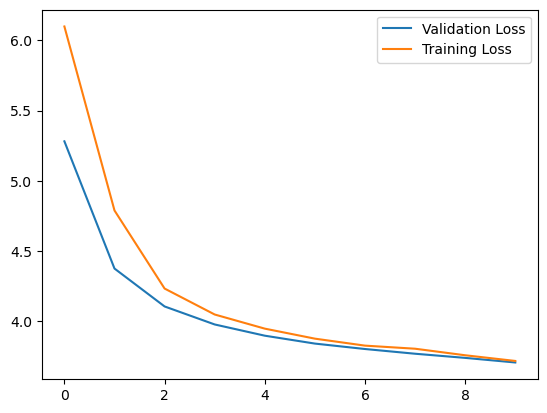

In [20]:
import matplotlib.pyplot as plt
plt.plot(np.array(train.results["val_loss"]), label='validation loss')
plt.plot(np.array(train.results["loss"]), label='training loss')
plt.legend(["Validation Loss", "Training Loss"])


In [8]:
import tensorflow as tf
from modules import Transformer
import time

ACTIVATIONS = {
    "td_sc": "relu",
    "log_amount_sc": "relu"
}
fieldInfo = FieldInfo(n_tcodes)
config = {}
config["ORDER"] = fieldInfo.DATA_KEY_ORDER
config["FIELD_STARTS_IN"] = fieldInfo.FIELD_STARTS_IN
config["FIELD_DIMS_IN"] = fieldInfo.FIELD_DIMS_IN
config["FIELD_STARTS_NET"] = fieldInfo.FIELD_STARTS_NET
config["FIELD_DIMS_NET"] = fieldInfo.FIELD_DIMS_NET
config["ACTIVATIONS"] = ACTIVATIONS

features = 26
d_embedding = 128
dff = 128
d_model = 128
batch_size = 64
seq_len = 80
maximum_position_encoding = 256
rate = 0.1
num_heads = 2
num_layers = 4
transformer = Transformer(features, dff, d_embedding, d_model, maximum_position_encoding,num_heads, num_layers,config, rate=0.1)
epochs = 3
train = Train(transformer)
with  tf.device('/gpu:1'):
    train.train(train_batches, epochs)

Epoch 1 Batch0 Loss 13.8080
Epoch 1 Batch50 Loss 9.7975
Epoch 1 Batch100 Loss 9.1993
Epoch 1 Batch150 Loss 8.8985
Epoch 1 Batch200 Loss 8.6787
Epoch 2 Batch0 Loss 6.1502
Epoch 2 Batch50 Loss 5.3255
Epoch 2 Batch100 Loss 5.1129
Epoch 2 Batch150 Loss 4.9872
Epoch 2 Batch200 Loss 4.8888
Epoch 3 Batch0 Loss 4.3338
Epoch 3 Batch50 Loss 4.3720
Epoch 3 Batch100 Loss 4.3117
Epoch 3 Batch150 Loss 4.2731
Epoch 3 Batch200 Loss 4.2370


In [18]:
from field_info import FieldInfo
ACTIVATIONS = {
    "td_sc": "relu",
    "log_amount_sc": "relu"
}
fieldInfo = FieldInfo(n_tcodes)
config = {}
config["ORDER"] = fieldInfo.DATA_KEY_ORDER
config["FIELD_STARTS_IN"] = fieldInfo.FIELD_STARTS_IN
config["FIELD_DIMS_IN"] = fieldInfo.FIELD_DIMS_IN
config["FIELD_STARTS_NET"] = fieldInfo.FIELD_STARTS_NET
config["FIELD_DIMS_NET"] = fieldInfo.FIELD_DIMS_NET
config["ACTIVATIONS"] = ACTIVATIONS

In [19]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return  -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)

loss_scce_logit = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [35]:
loss_scce_logit = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
LOSS_WEIGHTS = {
 'td_sc':1.,
 'month': 0.015,
 'day': 0.025,
 'dtme': 0.025,
 'dow': 0.01,
 'tcode_num': 1.,
 'log_amount_sc': 2.}

FIELD_STARTS_TAR = fieldInfo.FIELD_STARTS_TAR
FIELD_DIMS_TAR = fieldInfo.FIELD_DIMS_TAR
LOSS_TYPES = fieldInfo.LOSS_TYPES

def loss_function(real, preds):
    loss_parts = []
    loss_parts_weighted = []
    mask = tf.math.logical_not(tf.math.equal(tf.reduce_sum(real, axis=2), 0))
    for k, k_pred in preds.items():
        st = FIELD_STARTS_TAR[k]
        end = st + FIELD_DIMS_TAR[k]
        loss_type = LOSS_TYPES[k]
        if loss_type == "scce":
           loss_ = loss_scce_logit(real[:, :, st:end], k_pred)
        elif loss_type == "pdf":
           temp = -log_normal_pdf(real[:, :, st:end], k_pred[:,:,0:1], k_pred[:,:,1:2])
           loss_ = -log_normal_pdf(real[:, :, st:end], k_pred[:,:,0:1], k_pred[:,:,1:2])[:,:,0]
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_ = tf.reduce_sum(loss_)/tf.reduce_sum(mask) 

        loss_parts.append(loss_)
        loss_parts_weighted.append(loss_ * LOSS_WEIGHTS[k])
    return tf.reduce_sum(loss_parts_weighted)

In [22]:
# Create a TensorFlow dataset from the entire tensors
ds_all = tf.data.Dataset.from_tensor_slices((encoder.inp_tensor.astype(np.float32), encoder.tar_tensor.astype(np.float32)))

def make_batches(ds, buffer_size, batch_size):
    return ds.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

BUFFER_SIZE = ds_all.cardinality().numpy()
bs = 64  # batch size

# Create train batches from the entire dataset
train_batches = make_batches(ds_all, BUFFER_SIZE, bs)

In [29]:
# create only one sample of inp and tar to trace one iteration of loop
j = 0
for (batch_no, (inp, tar)) in enumerate(train_batches):
    if j == 0:
       break

In [30]:
from modules import InputEmbedLayer,InputEmbedLayer_Res, ResidualLayer, RandomNoise_Simulator_Normal, positional_encoding, MultiHeadAttention, Transformer, create_masks, DecoderLayer, Decoder
import tensorflow as tf
features = 26
d_embedding = 128
dff = 128
d_model = 128
batch_size = 64
seq_len = 80
maximum_position_encoding = 256
rate = 0.1
num_heads = 2
num_layers = 4
transformer = Transformer(features, dff, d_embedding, d_model, maximum_position_encoding,num_heads, num_layers,config, rate=0.1)

In [31]:
predictions, _ = transformer(tar, inp)

In [36]:
optimizer = tf.keras.optimizers.Adam() 
with tf.GradientTape() as tape:
      predictions, _ = transformer(tar, inp)
      loss  = loss_function(tar, predictions)
gradients = tape.gradient(loss, transformer.trainable_variables)
optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [33]:
gradients

[<tf.Tensor: shape=(26, 128), dtype=float32, numpy=
 array([[-5.5991858e-02, -4.6320087e-01, -3.2726312e-01, ...,
         -6.5956451e-03,  5.6365952e-03,  1.7642729e-02],
        [-7.5235269e-03, -4.2397165e-01, -3.2529721e-01, ...,
         -1.1657711e-04,  5.4569088e-04,  3.2669652e-02],
        [-4.3133512e-02, -4.5915547e-01, -3.3894372e-01, ...,
         -3.1944269e-03,  2.0855596e-02,  3.8216252e-02],
        ...,
        [-3.4662358e-02, -4.8779091e-01, -3.4685904e-01, ...,
         -1.9354026e-03,  4.9448375e-02,  4.3493457e-02],
        [-2.3784028e-01, -6.1516309e-01, -4.2151645e-01, ...,
         -5.2921399e-03,  3.6584988e-02,  1.5422128e-02],
        [-8.2564127e-01, -1.0874672e+00, -4.9909362e-01, ...,
         -3.1481612e-02,  1.4403084e-01, -2.0239559e-01]], dtype=float32)>,
 <tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-2.73765743e-01, -2.36311615e-01, -7.74204656e-02,  2.63273157e-03,
         1.00407982e-02, -8.79482552e-02, -5.42629557e-03, -2.42317794e-

In [34]:
predictions

{'tcode_num': <tf.Tensor: shape=(64, 80, 16), dtype=float32, numpy=
 array([[[-0.6983134 ,  0.11372446, -2.6972015 , ..., -1.3355415 ,
           3.2017114 , -2.5905895 ],
         [-0.1693564 ,  0.24517936, -3.224636  , ...,  0.5735683 ,
           1.6335124 , -2.2037024 ],
         [-0.7974376 ,  1.9183991 , -3.4158247 , ...,  0.15144038,
           0.6269475 , -2.3318946 ],
         ...,
         [-0.66661215,  0.85508114, -1.6347021 , ...,  0.7134897 ,
          -0.5568166 , -0.43835294],
         [-0.15276042,  0.25811666, -0.4110235 , ...,  0.27500594,
          -0.9744193 , -0.25375015],
         [-0.6794237 ,  1.1136942 , -0.33734304, ...,  1.2653682 ,
          -2.1916597 ,  1.6007918 ]],
 
        [[-0.8390302 , -0.83440506, -2.2633426 , ..., -1.1623777 ,
           3.4282298 , -1.7569948 ],
         [-1.0322988 ,  0.95897037, -3.9969263 , ...,  0.72559035,
           0.12851186, -2.0188468 ],
         [ 0.35024065,  2.0365145 , -2.4921443 , ...,  0.7412218 ,
          -0.347

In [13]:
transformer.trainable_variables

[<tf.Variable 'input_embed_layer/dense/Variable:0' shape=(26, 128) dtype=float32, numpy=
 array([[-0.18519771,  0.0640955 ,  0.1630831 , ...,  0.02978766,
          0.10082556,  0.00059572],
        [ 0.10546802,  0.11795834,  0.18593518, ...,  0.09318383,
          0.16104545,  0.14191875],
        [ 0.15883614,  0.157848  , -0.08295282, ..., -0.0697774 ,
          0.10127838, -0.13214591],
        ...,
        [ 0.15587161, -0.12970538, -0.10498066, ...,  0.15119396,
         -0.01639278, -0.05137227],
        [ 0.03032868,  0.13746497,  0.06266952, ..., -0.07041623,
         -0.18659757,  0.07521659],
        [-0.18496679, -0.0614811 , -0.17463274, ...,  0.03326951,
         -0.13606365,  0.0987507 ]], dtype=float32)>,
 <tf.Variable 'input_embed_layer/dense/Variable:0' shape=(128,) dtype=float32, numpy=
 array([ 0.07405648,  0.16218685,  0.06776766,  0.02419883,  0.13622189,
         0.05014855,  0.07309022, -0.07678477, -0.11403849, -0.190646  ,
        -0.06006065, -0.08973136,  0

In [37]:
from modules import InputEmbedLayer,InputEmbedLayer_Res, ResidualLayer, RandomNoise_Simulator_Normal, positional_encoding, MultiHeadAttention, Transformer, create_masks, DecoderLayer, Decoder
import tensorflow as tf
import time
ds_all = tf.data.Dataset.from_tensor_slices((encoder.inp_tensor.astype(np.float32), encoder.tar_tensor.astype(np.float32)))

def make_batches(ds, buffer_size, batch_size):
    return ds.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

BUFFER_SIZE = ds_all.cardinality().numpy()
bs = 64  # batch size
epochs = 3

features = 26
d_embedding = 128
dff = 128
d_model = 128
batch_size = 64
seq_len = 80
maximum_position_encoding = 256
rate = 0.1
num_heads = 2
num_layers = 4
transformer = Transformer(features, dff, d_embedding, d_model, maximum_position_encoding,num_heads, num_layers,config, rate=0.1)

optimizer = tf.keras.optimizers.Adam()
train_batches = make_batches(ds_all, BUFFER_SIZE, bs)

train_loss = tf.keras.metrics.Mean(name='train_loss')
with tf.device('/gpu:0'):
    for epoch in range(epochs):
        start = time.time()
        train_loss.reset_states()
        for (batch_no, (inp, tar)) in enumerate(train_batches):
            with tf.GradientTape() as tape:
                predictions, _ = transformer(tar, inp)
                loss = loss_function(tar, predictions)
            gradients = tape.gradient(loss, transformer.trainable_variables)
            optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
            train_loss(loss)
            if batch_no % 50 == 0:
                print(f'Epoch {epoch+1} Batch{batch_no} Loss{train_loss.result(): .4f}')
        


Epoch 1 Batch0 Loss 13.3776
Epoch 1 Batch50 Loss 7.0231
Epoch 1 Batch100 Loss 6.5842
Epoch 1 Batch150 Loss 6.3890
Epoch 1 Batch200 Loss 6.2644
Epoch 2 Batch0 Loss 5.8251
Epoch 2 Batch50 Loss 5.6746
Epoch 2 Batch100 Loss 5.5301
Epoch 2 Batch150 Loss 5.3906
Epoch 2 Batch200 Loss 5.2616
Epoch 3 Batch0 Loss 4.7593
Epoch 3 Batch50 Loss 4.5971
Epoch 3 Batch100 Loss 4.5143
Epoch 3 Batch150 Loss 4.4327
Epoch 3 Batch200 Loss 4.3720


In [7]:
encoder.count_variable_length_seqs_with_overlap(), encoder.count_seqs_with_overlap(), encoder.count_seqs_in_df()

(99101, 72764, 14354)

In [6]:
encoder.inp_tensor.shape

(14354, 81, 26)

In [ ]:
encoder.inp_tensor

In [ ]:
from modules import InputEmbedLayer,InputEmbedLayer_Res, ResidualLayer, RandomNoise_Simulator_Normal, positional_encoding, MultiHeadAttention, Transformer, create_masks, DecoderLayer, Decoder
import tensorflow as tf
ds_all = tf.data.Dataset.from_tensor_slices((encoder.inp_tensor.astype(np.float32), encoder.tar_tensor.astype(np.float32)))

def make_batches(ds, buffer_size, batch_size):
    return ds.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

BUFFER_SIZE = ds_all.cardinality().numpy()
bs = 64  # batch size

features = 26
d_embedding = 128
dff = 128
d_model = 128
batch_size = 64
seq_len = 80
maximum_position_encoding = 256
rate = 0.1
num_heads = 2
num_layers = 4
transformer = Transformer(features, dff, d_embedding, d_model, maximum_position_encoding,num_heads, num_layers,config, rate=0.1)

optimizer = tf.keras.optimizers.Adam()
train_batches = make_batches(ds_all, BUFFER_SIZE, bs)

train_loss = tf.keras.metrics.Mean(name='train_loss')
for epoch in range(epochs):
    start = time.time()
    train_loss.reset_states()
    for (batch_no, (inp, tar)) in enumerate(train_batches):
        with tf.GradientTape() as tape:
            predictions, _ = transformer(tar, inp)
            loss = loss_function(tar, predictions)
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        train_loss(loss)
        if batch_no % 50 == 0:
            print(f'Epoch {epoch+1} Batch{batch_no} Loss{train_loss.result(): .4f}')
    


In [18]:
# from modules import InputEmbedLayer,InputEmbedLayer_Res, ResidualLayer, RandomNoise_Simulator_Normal, positional_encoding, MultiHeadAttention, create_masks, DecoderLayer
# import tensorflow as tf
# features = 26
# d_embedding = 128
# dff = 128
# d_model = 128
# batch_size = 64
# seq_len = 80
# maximum_position_encoding = 256
# rate = 0.1
# num_heads = 2
# num_layers = 4
# z = RandomNoise_Simulator_Normal(batch_size, seq_len, features)

# #Transformer Model
# input_ = tf.keras.layers.Input(shape=(None, features))
# x = InputEmbedLayer(features, dff , d_embedding)(input_)

# pos_encoding = positional_encoding(maximum_position_encoding, d_embedding)   #(1, maximum_position_encoding=256, d_model=128)

# seq_len = tf.shape(x)[1]
# x += pos_encoding[:, :seq_len, :]     #x is the output of Input layer

# x = tf.keras.layers.Dropout(rate)(x, training=True)

# attention_weights = {}
# mask, _ = create_masks(tar)
# for i in range(num_layers):
#     d_inp_decoder = tf.keras.backend.int_shape(x)[-1]
#     x, attentionweights = DecoderLayer(d_inp_decoder, d_model, num_heads, dff)(x, True, mask)
#     attention_weights['decoder_layer{}'.format(i+1)] = attentionweights

# final_output = tf.keras.layers.Dense(d_model, activation=None)(x)


# model = tf.keras.models.Model(input_, final_output)
